In [ ]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)


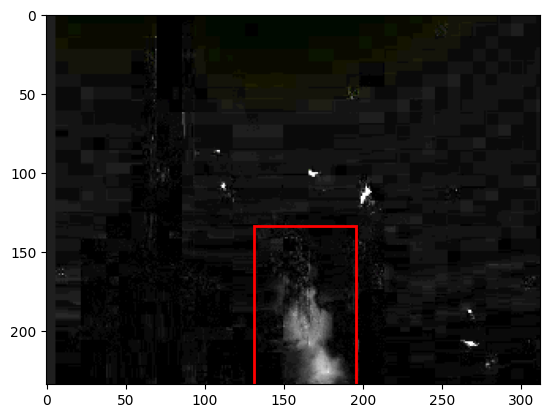

In [40]:
prompt = ["<OPEN_VOCABULARY_DETECTION>White semi-transparent smoke on a black background"]
        #   "<OPEN_VOCABULARY_DETECTION>White birds on a black background"]
image = Image.open("test.png")


inputs = processor(text=prompt, images=[image] * len(prompt), return_tensors="pt", padding=True).to(device, torch_dtype)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)

res = []
for i in range(len(prompt)):
    res_ = processor.post_process_generation(generated_text[i], task="<OPEN_VOCABULARY_DETECTION>", image_size=(image.width, image.height))
    res_ = res_["<OPEN_VOCABULARY_DETECTION>"]
    res.append(res_)

# show the boxes xyxy
import pylab
pylab.imshow(image)
for r in res:
    for box in r["bboxes"]:
        x0, y0, x1, y1 = box
        pylab.gca().add_patch(pylab.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor="red", lw=2))